In [13]:
import pandas as pd
import seaborn as sns

import read_ttf_price
import matplotlib.pyplot as plt

# Short-term marginal electricity supplier in Spain

This notebook does a correlation analysis between prices of natural gas in Europe and prices of the wholesale electricity market in Spain. The rules of the EU electricity market are designed to set prices at the marginal price of electricity production, because in economic theory it is the optimal price. If prices are heavily correlated then changes in natural gas price explain most of the changes in electricity price, indicating that it is frequently power plants using natural gas are the marginal supplier of electricity to the wholesale market.

## read data

read marginal electricity price. This data comes from queries to the ENTSOE transparency platform, and has been reformatted from convenience

In [2]:
marginal_price = pd.read_csv('../data/entsoe/spain_.csv',
                             index_col='Date',
                             parse_dates=True)

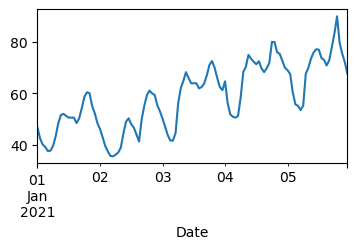

In [3]:
# example of electricity prices
marginal_price.loc['2021-01-01':'2021-01-05'].Electricity_price.plot(
figsize=(4,2));

read TTF data, this is a reference price for natural gas in Europe. We use it as a proxy of natural gas price in Spain.

In [4]:
ttf = read_ttf_price.main()

In [5]:
ttf.sample()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-02-01,15.694,19.3,21.41,15.485,684.35K,-20.81%


## Transform

In [6]:
def mothly_agg(timeseries):

    ts = timeseries.copy()
    ts = ts.to_frame()

    ts['date'] = ts.index.map(lambda x:f"{x.year}-{x.month}")

    ts = ts.groupby('date').mean()
    ts.index = pd.to_datetime(ts.index)
    ts = ts[ts.columns[0]]
    return ts

we aggregate the electricity prices to monthly averages to coincide with the time resolution of the natural gas price

In [7]:
marginal_price_monthly = marginal_price.apply(lambda x:mothly_agg(x),axis=0)

In [8]:
prices_df_monthly = pd.concat([marginal_price_monthly,
                               ttf.Price.rename('NG_price')],
                               axis=1,join='inner')

In [9]:
prices_df_monthly['year'] = prices_df_monthly.index.year

## Analysis

we exclude the year where the "Iberian Exception" took place, as this policy was meant to temporarely avoid that natural gas turbines set the price of the wholesale market

In [10]:
# excluding the year of the "iberian exception"
pearson_corr = prices_df_monthly.loc['2016':'2021',['Electricity_price',
    'NG_price']].corr().loc['Electricity_price','NG_price']

In [11]:
print(f"correlation coeff. Between electricity and natural gas price: {pearson_corr:.2%}")

correlation coeff. Between electricity and natural gas price: 92.57%


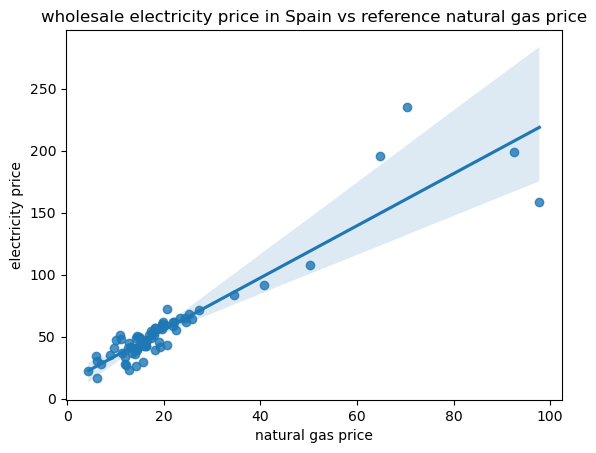

In [16]:
sns.regplot(x='NG_price',y='Electricity_price',
            data=prices_df_monthly.loc['2016':'2021',
            ['Electricity_price','NG_price','year']]);

plt.ylabel('electricity price');
plt.xlabel('natural gas price');
plt.title('wholesale electricity price in Spain vs reference natural gas price');